In [11]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn

## 预览图片

In [12]:
content_img=Image.open('content_image.jpg')

In [13]:
style_img=Image.open('style_image.jpg')

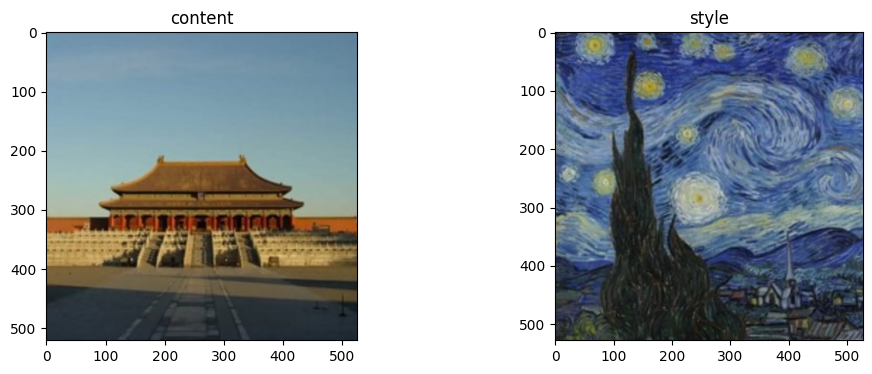

In [14]:
fig,axs=plt.subplots(1,2,figsize=(12,4))
axs[0].imshow(content_img)
axs[0].set_title("content")
axs[1].imshow(style_img)
axs[1].set_title("style")
plt.show()

In [15]:
import os
import torchvision
os.environ['TORCH_HOME'] = 'D:/torch_model'
pretrained_net = torchvision.models.vgg19(pretrained=True)

In [16]:
pretrained_net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [17]:
style_layers=[0,5,10,19,28]
content_layers=[25]
style_layers+content_layers

[0, 5, 10, 19, 28, 25]

In [18]:
net=nn.Sequential(*[pretrained_net.features[i] for i in range(max(style_layers+content_layers)+1)])

In [19]:
net

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

##  获取内容层和样式层的输出

In [20]:
def extract_features(X,content_layers,style_layers):
    contents,styles=[],[]
    for i in range(len(net)):
        X=net[i](X)
        if i in content_layers:
            contents.append(X)
        if i in style_layers:
            styles.append(X)
    return contents,styles

## 对内容图像提取内容特征，对风格图像提取风格特征

In [21]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

### PIL->Tensor，Tensor->PIL

In [22]:
def preprocess(img,img_shape):
    transform=transforms.Compose([
        transforms.Resize(img_shape),
        transforms.ToTensor(),
        transforms.Normalize(mean=rgb_mean,std=rgb_std)
    ])
    return transform(img).unsqueeze(0)

def postprocess(img):
    img=img[0]
    img=torch.clamp(img.permute(1,2,0)*rgb_std+rgb_mean,0,1)
    to_pil_img=transforms.ToPILImage()
    return to_pil_img(img.permute(2,0,1))

In [23]:
def get_contents(image_shape):
    content_X=preprocess(content_img,image_shape)
    contents_Y,_=extract_features(content_X,content_layers,style_layers)
    return content_X,contents_Y

def get_styles(image_shape):
    style_X=preprocess(style_img,image_shape)
    _,styles_Y=extract_features(style_X,content_layers,style_layers)
    return style_X,styles_Y

## 内容损失

In [24]:
def content_loss(Y_hat,Y):
    return torch.square(Y_hat-Y.detach()).mean()

## 风格损失

In [25]:
def gram(X):
    num_channels=X.shape[1]
    n=X.numel()//num_channels
    X=X.reshape((num_channels,n))
    return torch.matmul(X,X.T)/(num_channels*n)

In [26]:
def style_loss(Y_hat,gram_Y):
    return torch.square(gram(Y_hat)-gram_Y.detach()).mean()

## 全变分损失

In [27]:
def tv_loss(Y_hat):
    return 0.5*(torch.abs(Y_hat[:,:,1:,:]-Y_hat[:,:,:-1,:]).mean()+
               torch.abs(Y_hat[:,:,:,1:]-Y_hat[:,:,:,:-1]).mean())

## 损失函数

In [28]:
content_weight,style_weight,tv_weight=1,1e3,10
def compute_loss(X,contents_Y_hat,styles_Y_hat,contents_Y,style_Y_gram):
    contents_l=[content_loss(Y_hat,Y)*content_weight for Y_hat,Y in zip(contents_Y_hat,contents_Y)]
    styles_l=[style_loss(Y_hat,Y)*style_weight for Y_hat,Y in zip(styles_Y_hat,style_Y_gram)]
    tv_l=tv_loss(X)*tv_weight
    l=sum(10*styles_l+contents_l+[tv_l])
    return contents_l,styles_l,tv_l,l

## 初始化合成图像

In [29]:
class SynthesizedImage(nn.Module):
    def __init__(self,img_shape):
        super(SynthesizedImage,self).__init__()
        self.weight=nn.Parameter(torch.rand(*img_shape))
        
    def forward(self):
        return self.weight

In [30]:
def get_inits(X,lr,styles_Y):
    gen_img=SynthesizedImage(X.shape)
    gen_img.weight.data.copy_(X.data)
    optimizer=torch.optim.Adam(gen_img.parameters(),lr=lr)
    styles_Y_gram=[gram(Y) for Y in styles_Y]
    return gen_img(),styles_Y_gram,optimizer

## 训练模型

In [31]:
import time
def train(X,contents_Y,styles_Y,lr,num_epochs):
    X,styles_Y_gram,optimizer=get_inits(X,lr,styles_Y)
    plt.ion()
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(7,2.5))
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.set_xlim(10,num_epochs)
    ax1.set_ylim(0,None)
    ax1.legend(['content','style','TV'])
    content_losses = []
    style_losses = []
    tv_losses = []
    epochs = []
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        contents_Y_hat,styles_Y_hat=extract_features(X,content_layers,style_layers)
        contents_l,styles_l,tv_l,l=compute_loss(X,contents_Y_hat,styles_Y_hat,contents_Y,styles_Y_gram)
        l.backward()
        optimizer.step()
        
        content_loss_val=float(sum(contents_l))
        style_loss_val=float(sum(styles_l))
        tv_loss_val=float(tv_l)
        content_losses.append(content_loss_val)
        style_losses.append(style_loss_val)
        tv_losses.append(tv_loss_val)
        epochs.append(epoch+1)
        
        if(epoch+1)%10==0:
            ax1.clear()
            ax1.plot(epochs,content_losses,label='content')
            ax1.plot(epochs,style_losses,label='style')
            ax1.plot(epochs,tv_losses,label='TV')
            ax1.set_xlabel('epoch')
            ax1.set_ylabel('loss')
            ax1.set_xlim(10, num_epochs)
            ax1.legend()
            ax1.grid(True)

           
            ax2.clear()
            img = postprocess(X)
            ax2.imshow(img)
            ax2.set_title(f'Epoch {epoch + 1}')
            ax2.axis('off')

           
            fig.canvas.draw()
            fig.canvas.flush_events()
            time.sleep(0.01)  
    plt.ioff() 
    plt.show()
    return X

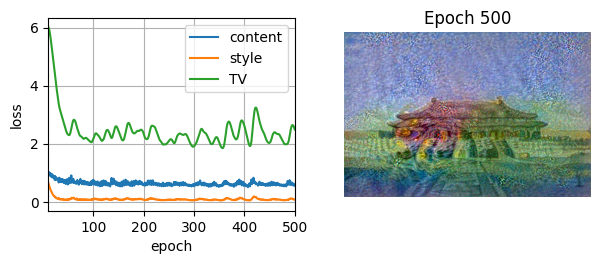

In [33]:
image_shape=(300,450)
content_X,contents_Y=get_contents(image_shape)
_,styles_Y=get_styles(image_shape)
output=train(content_X,contents_Y,styles_Y,0.3,500)